In [80]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.adefc_2dm as adefc
import apra_pop_models.efc_utils as efc_utils

from scipy.optimize import minimize

Nwaves = 9
wavelength_c = 650e-9
bw = 0.10
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
est_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)

dm1_flat = utils.load_fits('dm1_flat_command.fits')

[[6.17500e-07 6.25625e-07 6.33750e-07]
 [6.41875e-07 6.50000e-07 6.58125e-07]
 [6.66250e-07 6.74375e-07 6.82500e-07]]
[6.25625e-07 6.50000e-07 6.74375e-07]


In [36]:
bandpasses.flatten()

array([6.337500e-07, 6.378125e-07, 6.418750e-07, 6.459375e-07,
       6.500000e-07, 6.540625e-07, 6.581250e-07, 6.621875e-07,
       6.662500e-07])

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


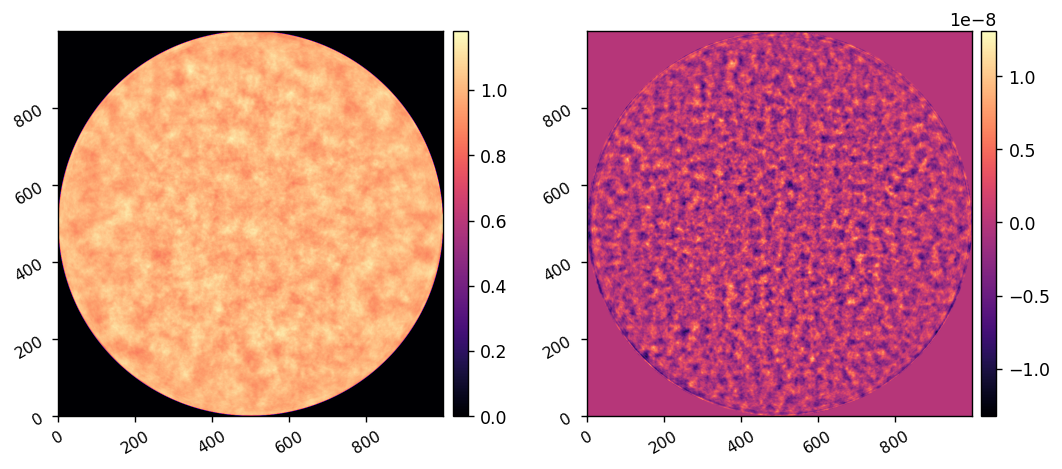

In [81]:
reload(fresnel)
I = fresnel.CORO(
    dm1_ref=xp.rot90(xp.rot90(dm1_flat))
)
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

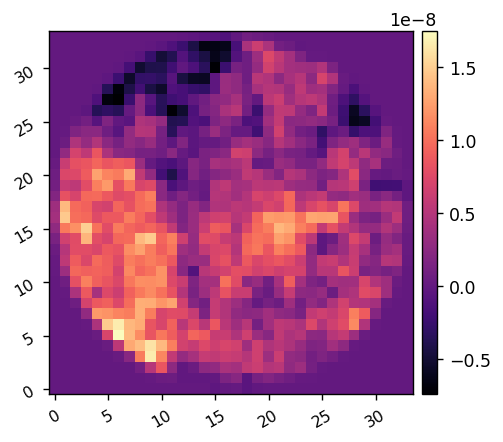

In [34]:
imshow1(dm1_flat)

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


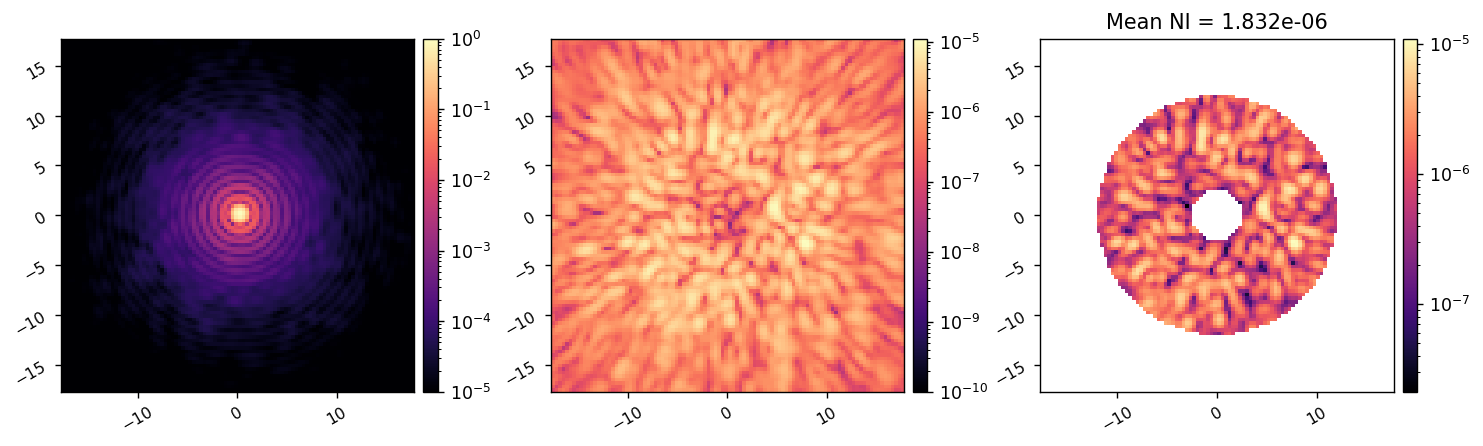

In [68]:
reload(fresnel)
I = fresnel.CORO(dm1_ref=xp.rot90(xp.rot90(dm1_flat)))
I.use_opds = True
# I.set_dm1(xp.rot90(xp.rot90(dm1_flat)))
I.bandpasses = bandpasses 

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

reload(efc_utils)
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'Mean NI = {mean_ni:.3e}', 
        pxscl=I.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)


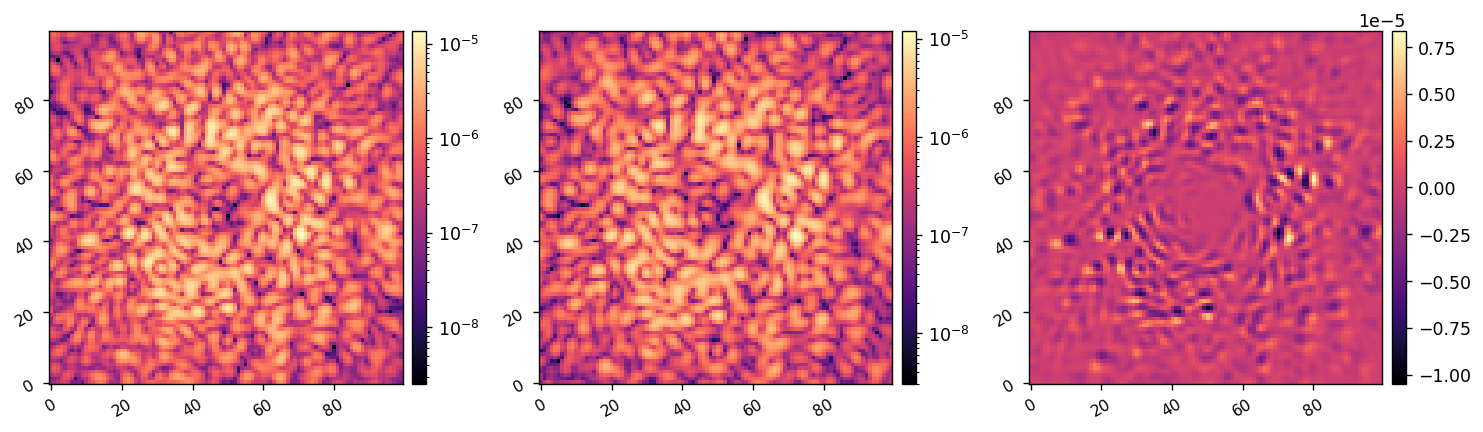

In [42]:
im_bp1 = I.snap(1)
im_bp3 = I.snap(3)
diff = im_bp3 - im_bp1
imshow3(im_bp1, im_bp3, diff, lognorm1=True, lognorm2=True, )

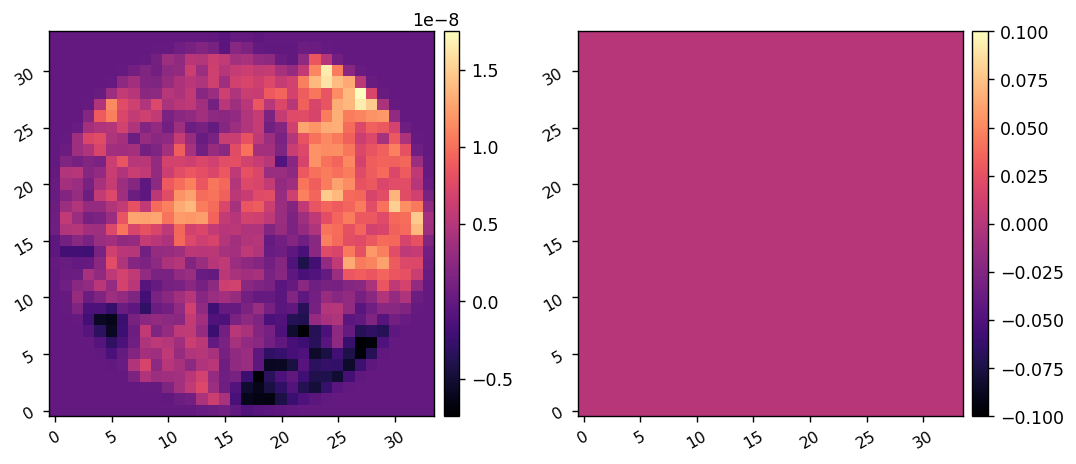

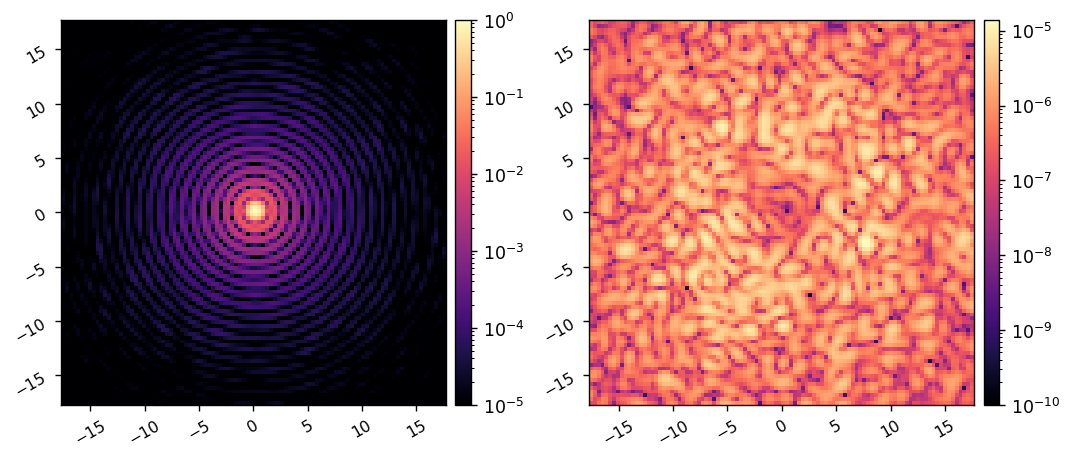

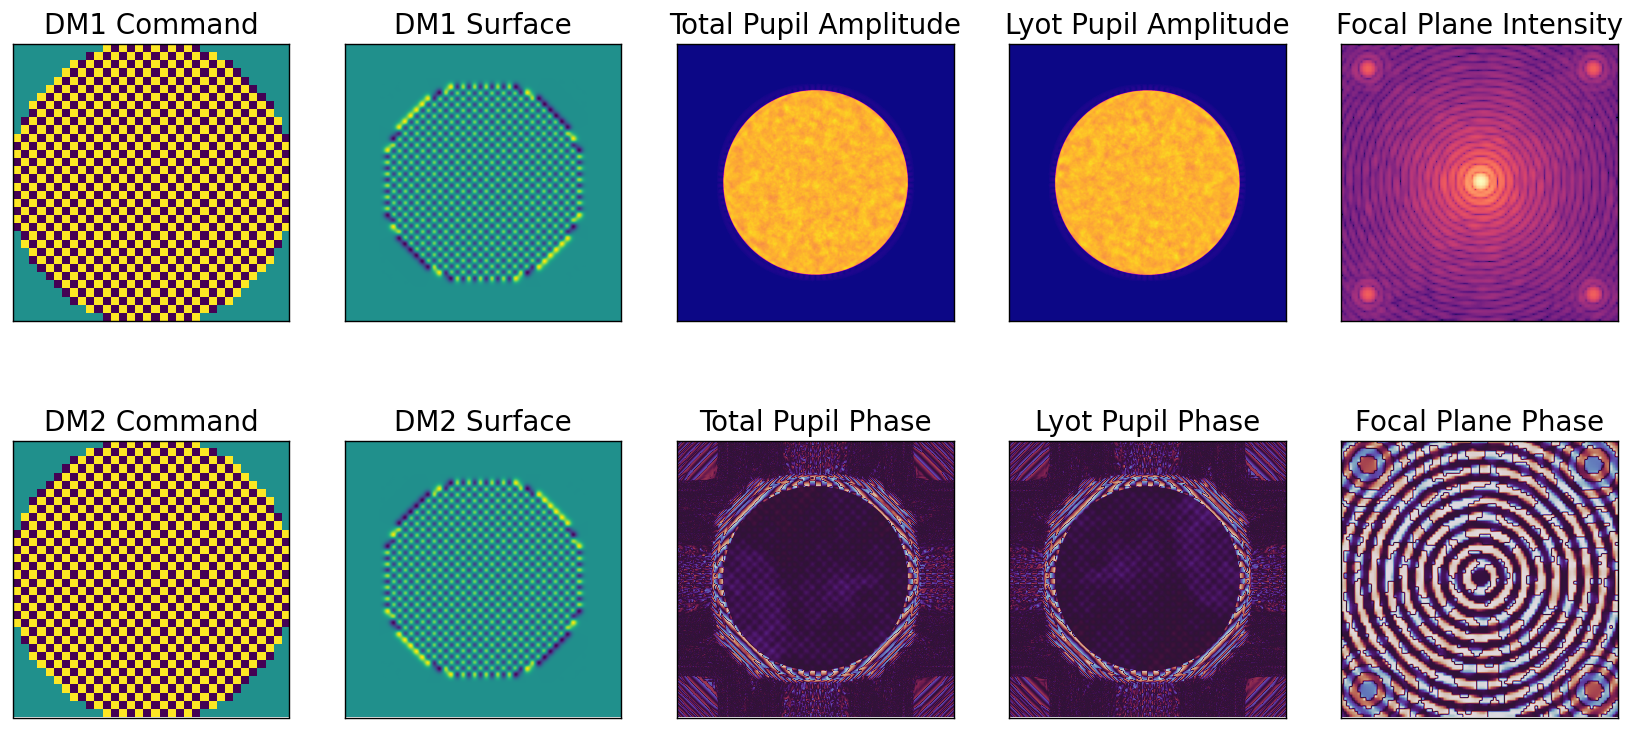

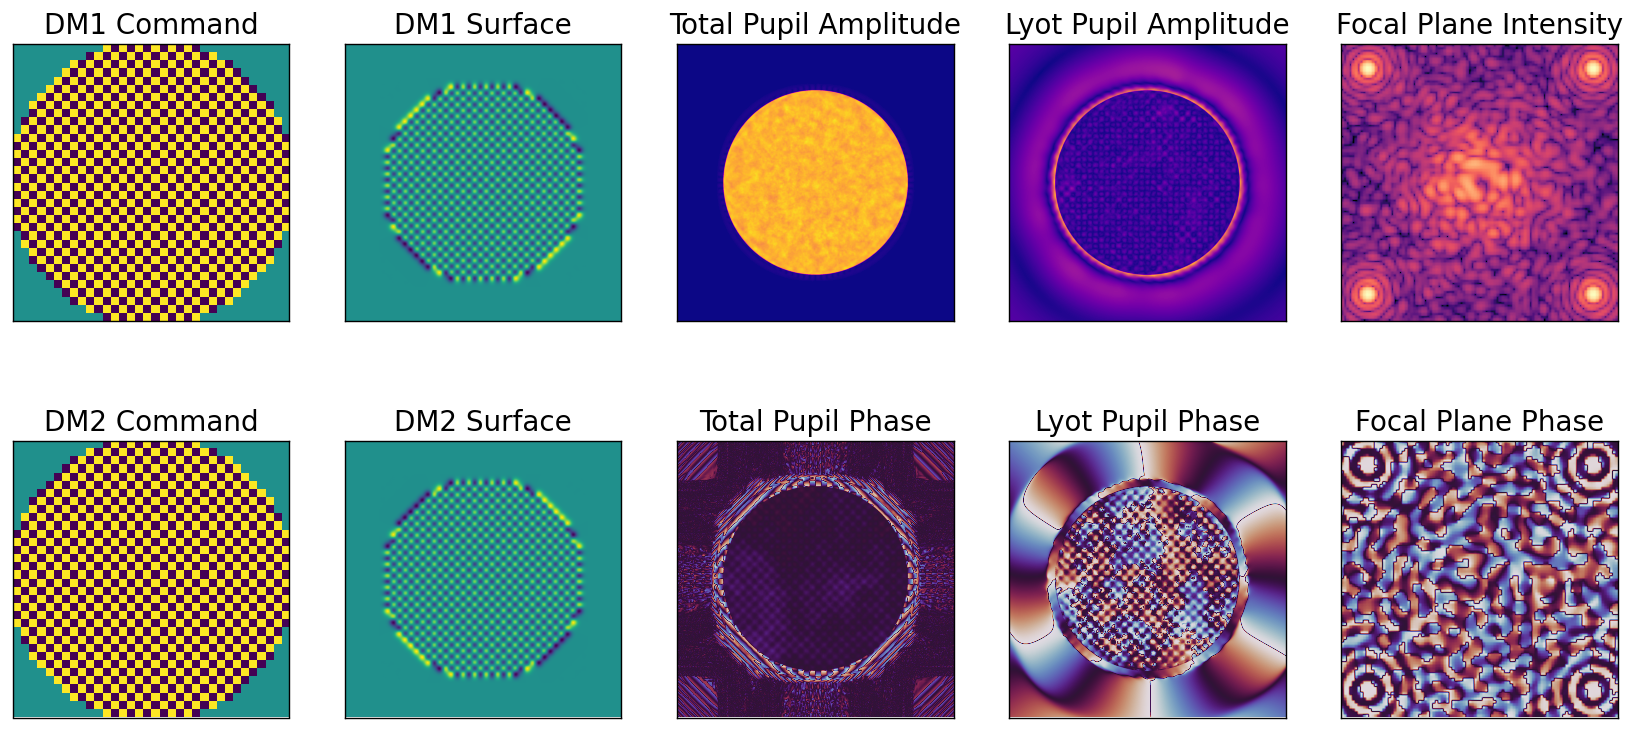

In [69]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.AMP = AMP
M.OPD = OPD

M.flip_dm = True
M.flip_lyot = True

M.set_dm1(I.get_dm1())
M.set_dm2(I.get_dm2())
imshow2(M.get_dm1(), M.get_dm2())

M.setattr('use_vortex', False)
model_psf = xp.abs(M.calc_wf())**2
M.setattr('Imax_ref', xp.max(model_psf))
model_psf /= M.Imax_ref

M.setattr('use_vortex', True)
model_coro_im = xp.abs(M.calc_wf())**2

imshow2(model_psf, model_coro_im,
        pxscl=M.psf_pixelscale_lamDc, lognorm=True, vmin1=1e-5, vmin2=1e-10)

dm1_command, dm2_command = ( xp.zeros((M.Nact, M.Nact)), xp.zeros((M.Nact, M.Nact)) )
# command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
dm1_command = 10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
dm2_command = -10e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)

acts = xp.concatenate([dm1_command[M.dm_mask], dm2_command[M.dm_mask]])
fpwf = M.forward(acts, M.wavelength_c, use_vortex=0, fancy_plot=1)
fpwf = M.forward(acts, M.wavelength_c, use_vortex=1, fancy_plot=1)

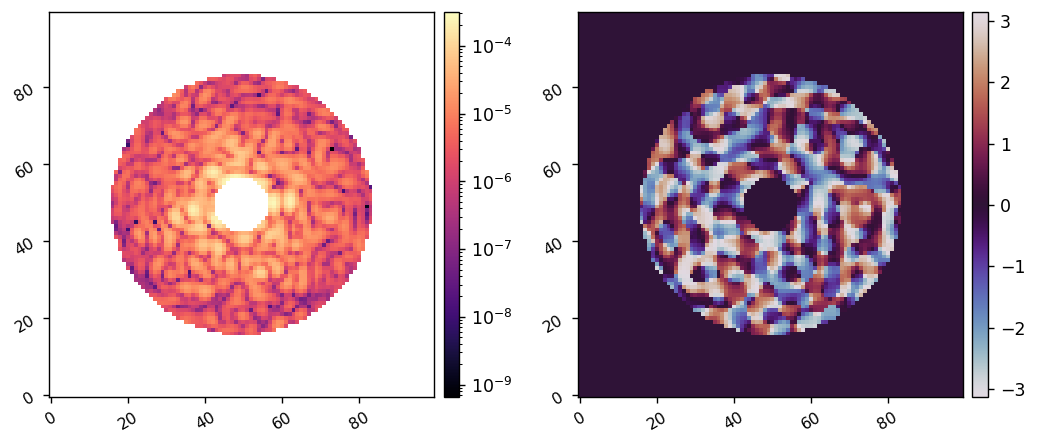

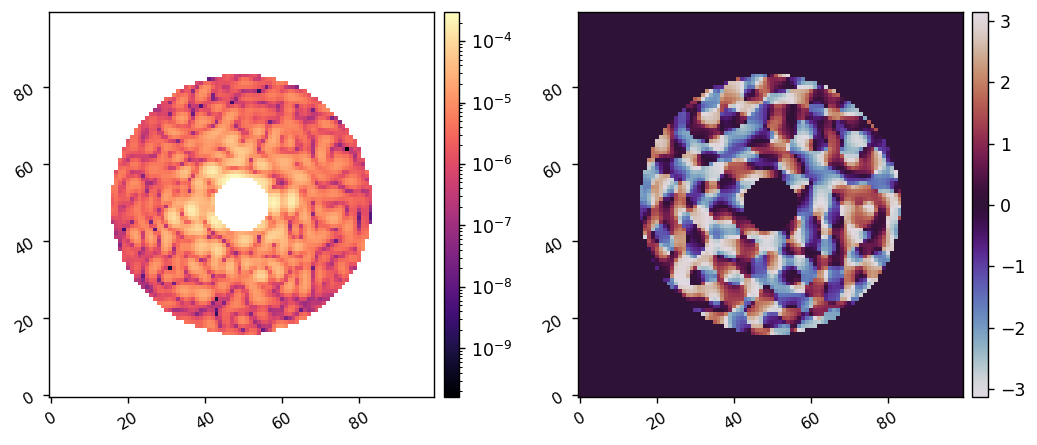

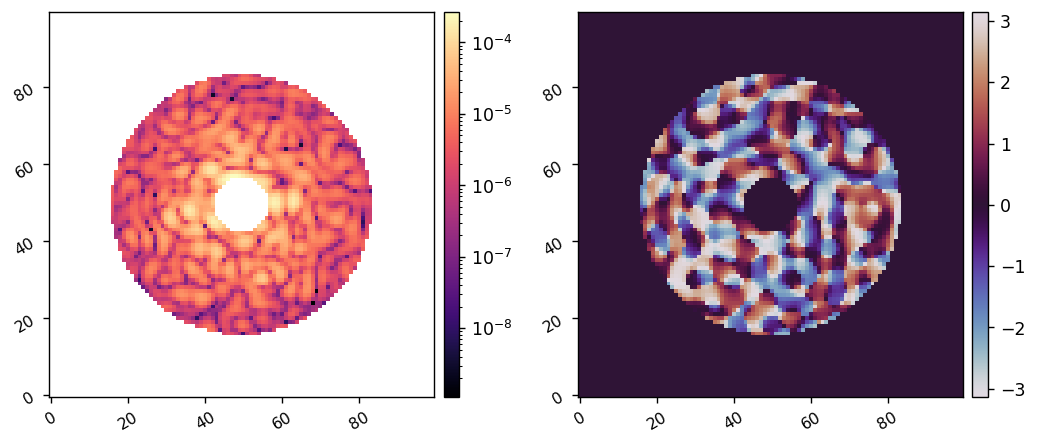

In [13]:
reload(adefc)
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)

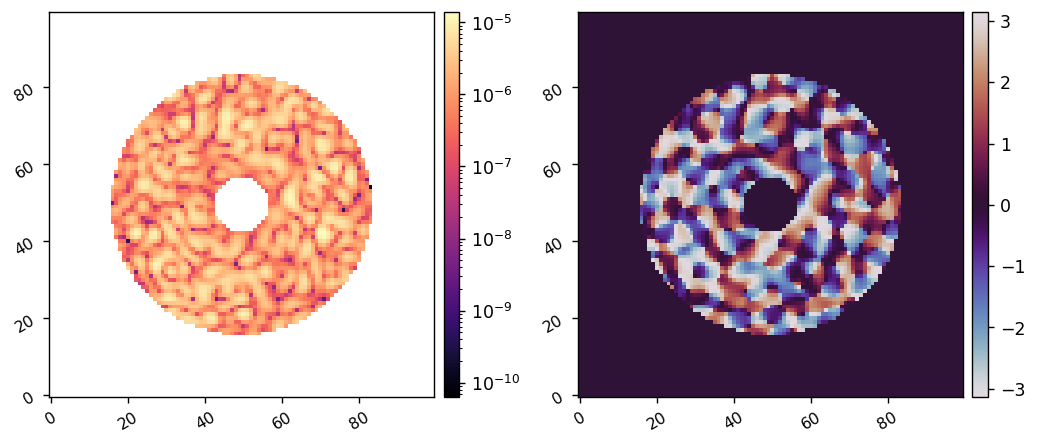

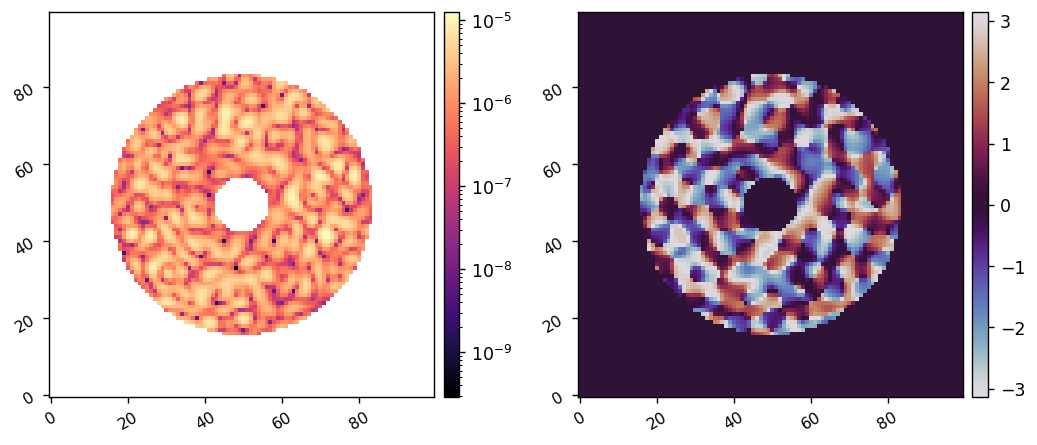

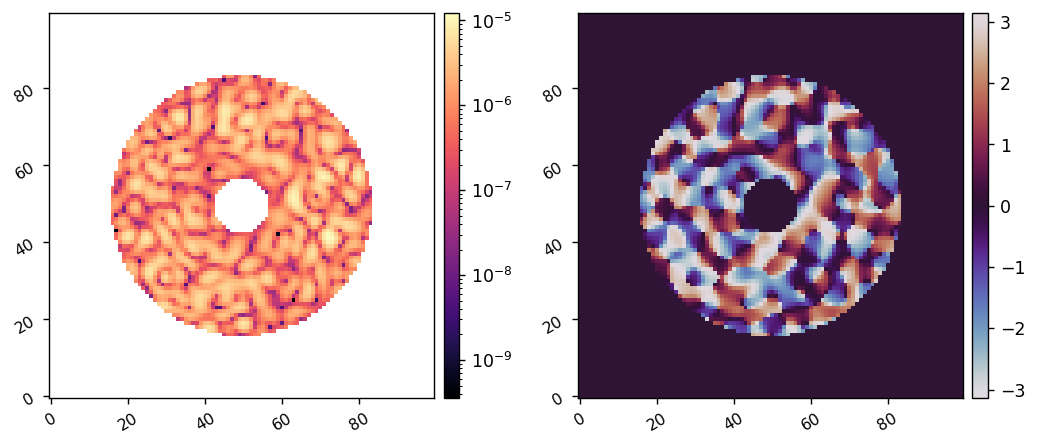

	Cost-function J_delE: 0.007
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.007
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000

	Cost-function J_delE: 0.006
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.006
	Total cost-function value: 1.000



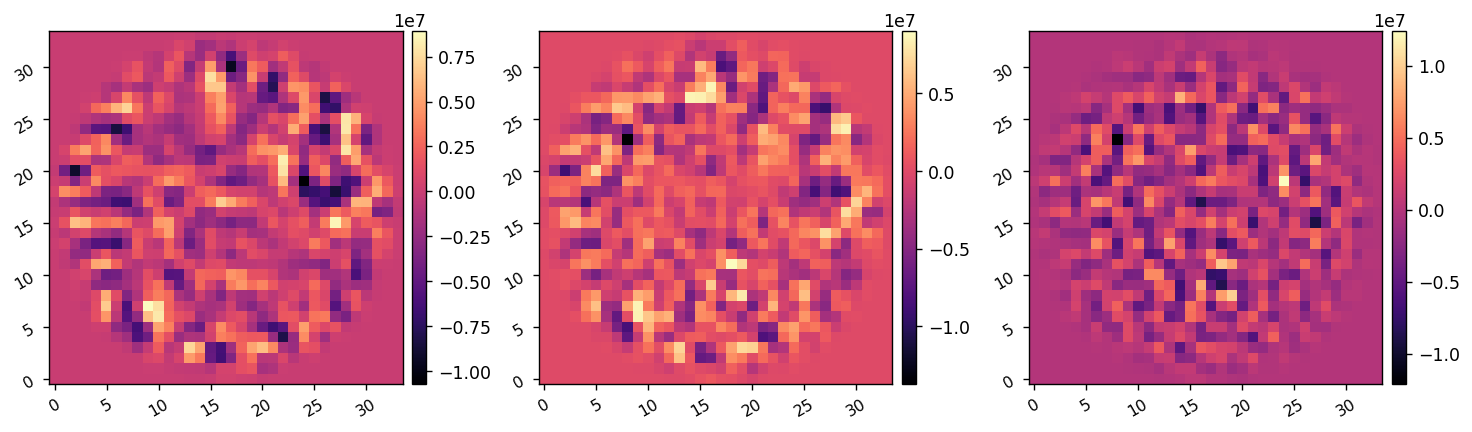

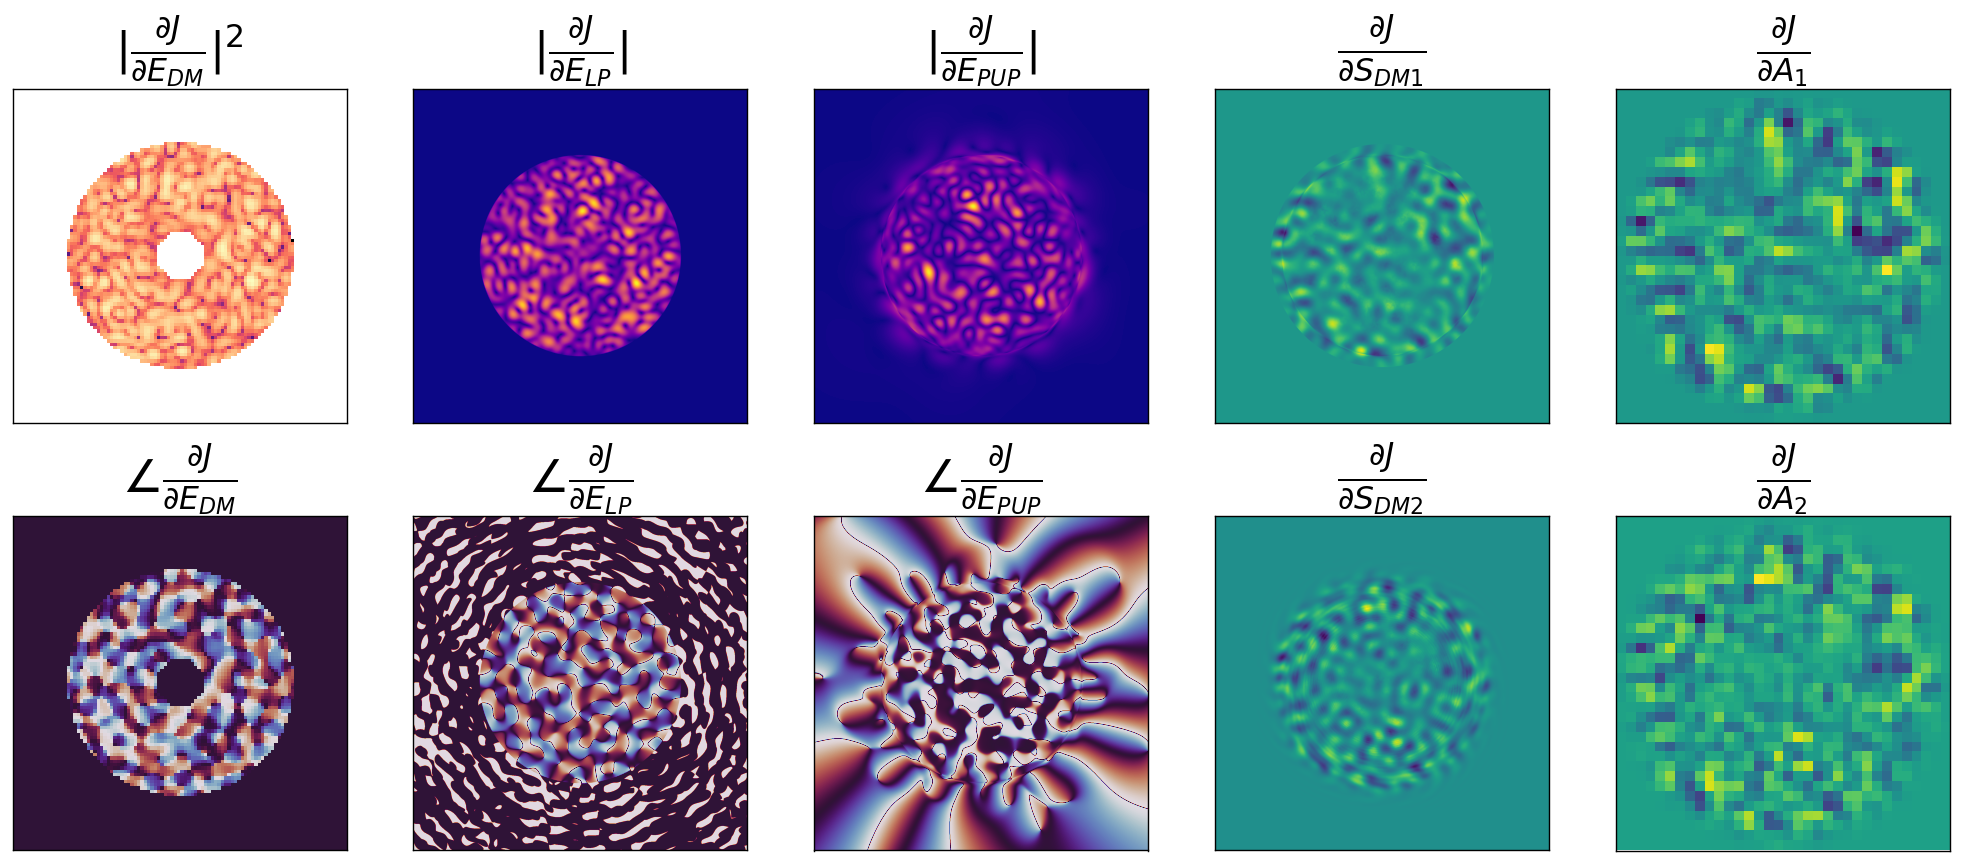

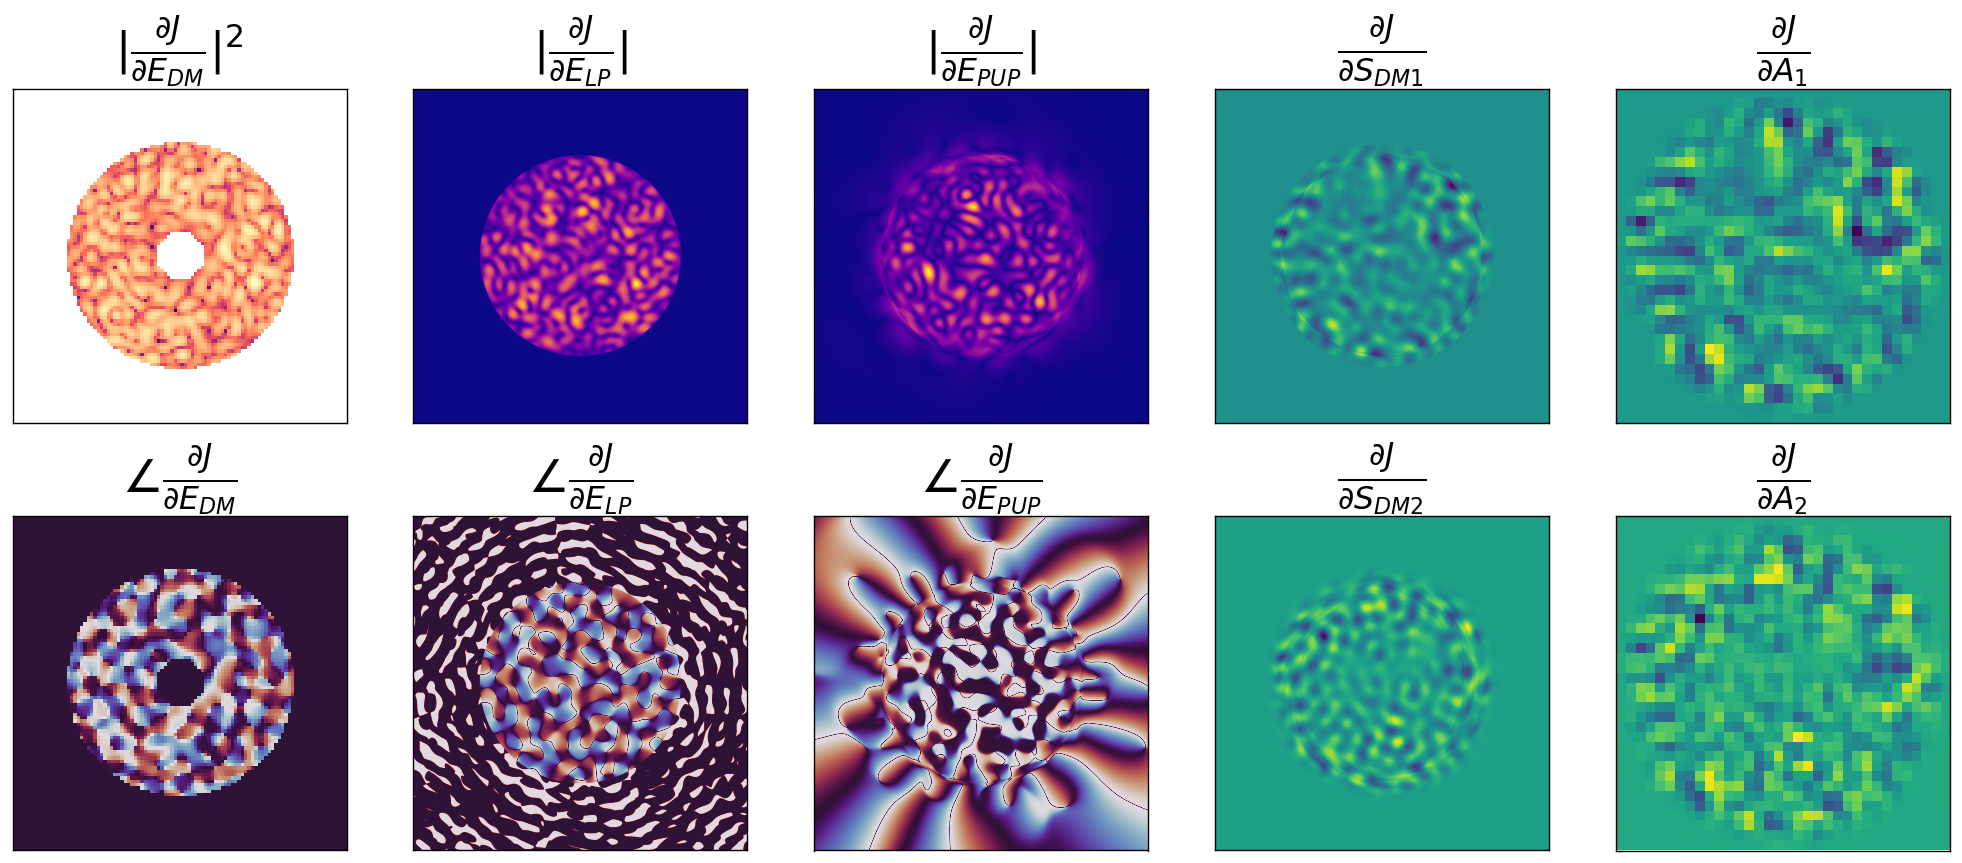

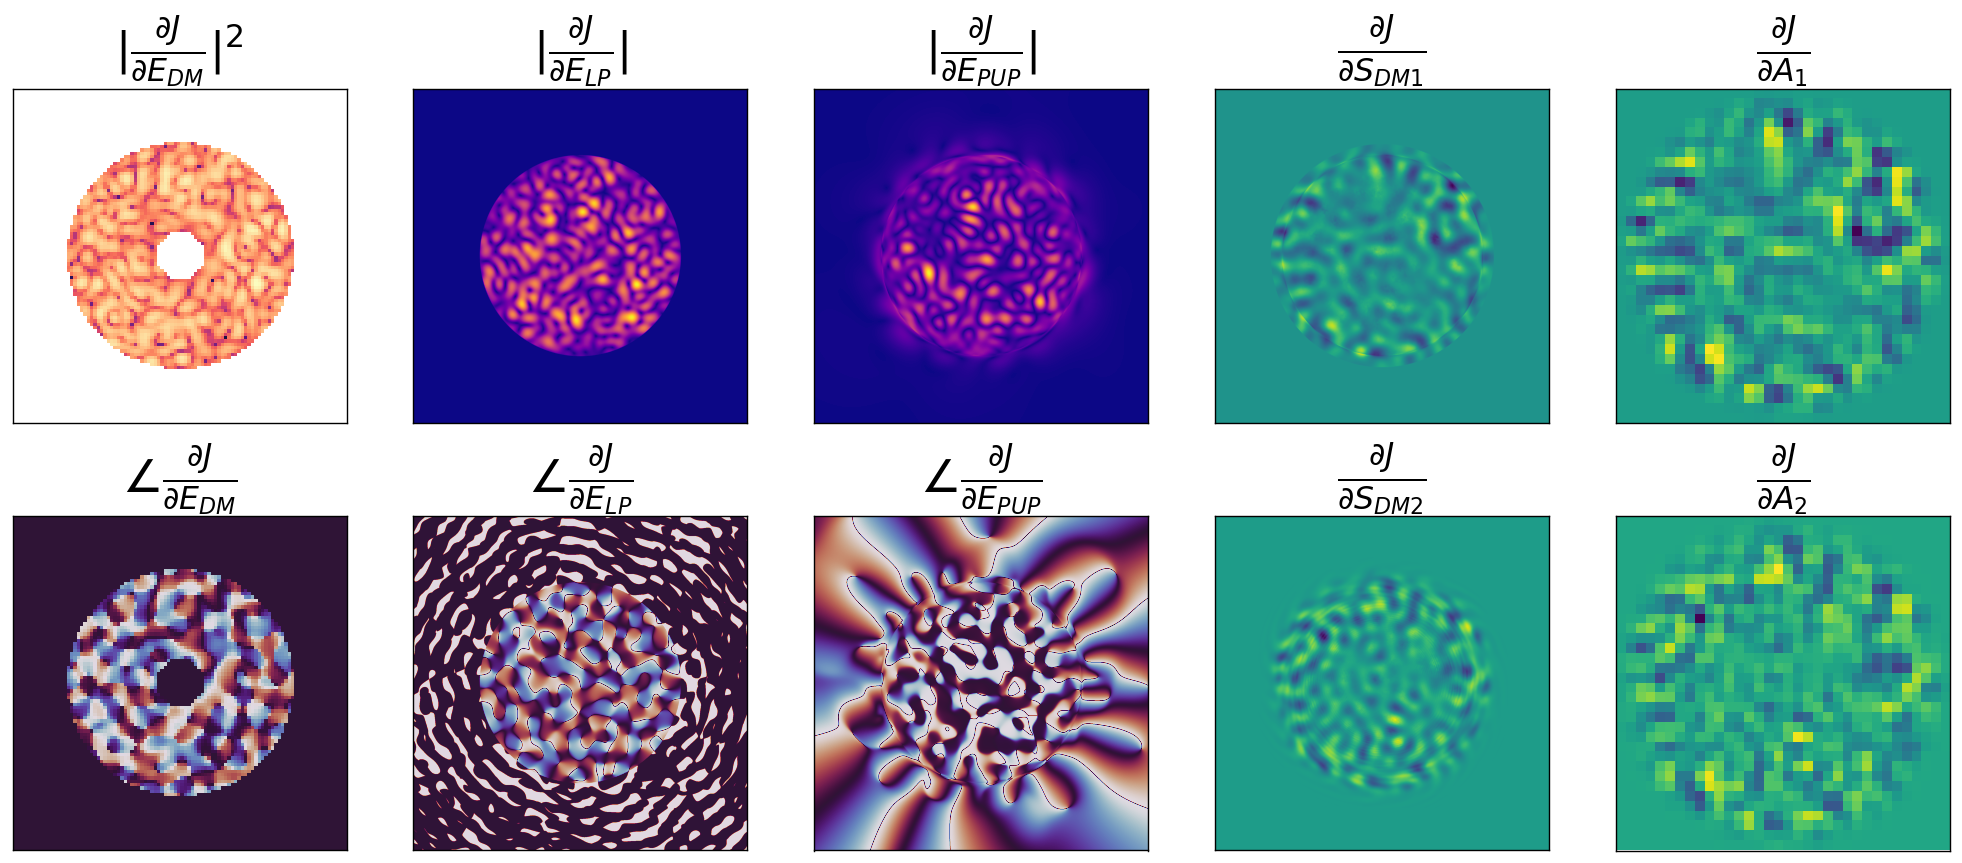

In [70]:
reload(fraunhofer)
from apra_pop_models import imshows
reload(imshows)
acts = xp.zeros(M.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=1)
r_cond = 1e-3

del_acts = np.zeros(M.Nacts)
J, dJ_dA = fraunhofer.val_and_grad_bb(del_acts, M, acts, E_abs, control_mask, est_waves, r_cond, 
                                        verbose=True, 
                                        # plot=True, 
                                        fancy_plot=True)

dm1_grad = fraunhofer.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = fraunhofer.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(dm1_grad, dm2_grad, dm2_grad-dm1_grad)

In [71]:
reload(fraunhofer)

acts = xp.zeros(M.Nacts)
# acts = fits.getdata('ad_test_acts.fits')

I.reset_dms()
I.add_dm1(fraunhofer.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
I.add_dm2(fraunhofer.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
coro_im = I.snap()
E_abs = adefc.calc_wfs(I, est_waves, control_mask, plot=0)

r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'maxls':50,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(
    fraunhofer.val_and_grad_bb, 
    jac=True, 
    x0=del_acts0,
    args=(M, acts, E_abs, control_mask, est_waves, r_cond, True, False), 
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=bfgs_opts,
)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.37207D+07


 This problem is unconstrained.



At iterate    1    f=  7.91273D-01    |proj g|=  1.86835D+07

At iterate    2    f=  4.99978D-01    |proj g|=  6.07174D+06

At iterate    3    f=  4.12381D-01    |proj g|=  5.18157D+06

At iterate    4    f=  2.39656D-01    |proj g|=  5.25689D+06

At iterate    5    f=  1.95530D-01    |proj g|=  1.33190D+07

At iterate    6    f=  1.05508D-01    |proj g|=  3.00601D+06

At iterate    7    f=  9.26307D-02    |proj g|=  1.72719D+06

At iterate    8    f=  7.87640D-02    |proj g|=  1.90016D+06

At iterate    9    f=  6.24973D-02    |proj g|=  2.96651D+06

At iterate   10    f=  5.01013D-02    |proj g|=  3.30205D+06

At iterate   11    f=  3.95384D-02    |proj g|=  1.16253D+06

At iterate   12    f=  3.23531D-02    |proj g|=  1.33772D+06

At iterate   13    f=  2.65109D-02    |proj g|=  1.55595D+06

At iterate   14    f=  2.39234D-02    |proj g|=  2.39208D+06

At iterate   15    f=  1.91554D-02    |proj g|=  5.64035D+05

At iterate   16    f=  1.78118D-02    |proj g|=  5.66491D+05

At iter

1.832156444754296e-06 1.9670235256168162e-07


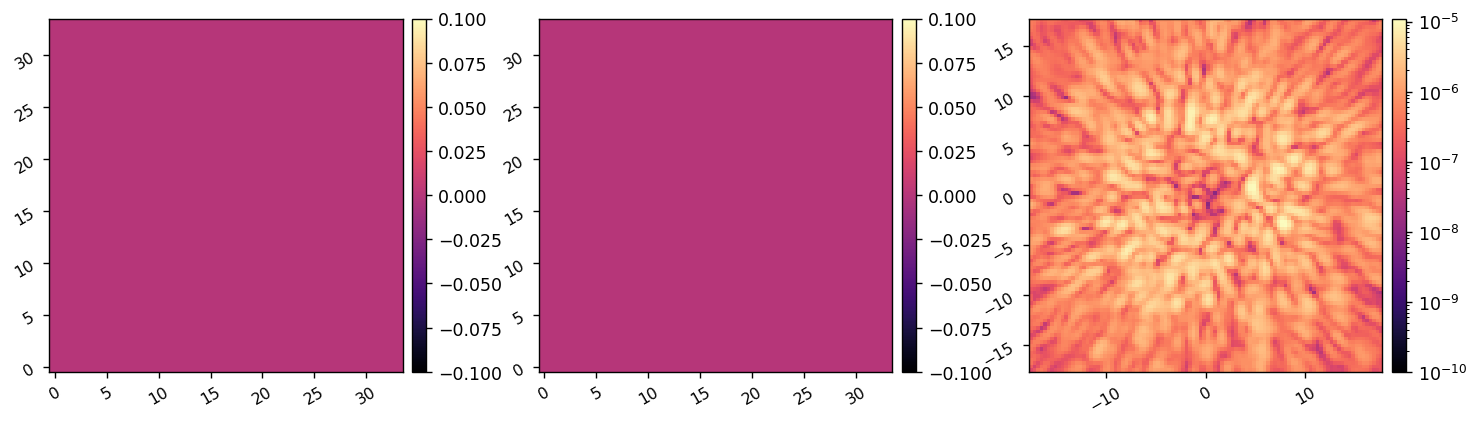

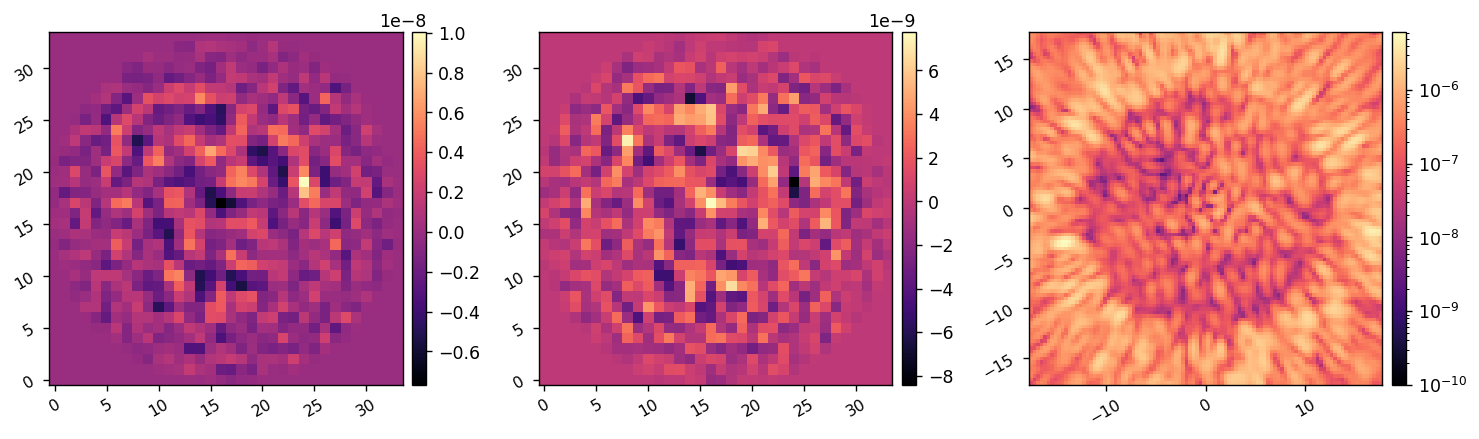

In [72]:
old_dm1 = fraunhofer.acts_to_command(acts[:M.Nacts//2], I.dm_mask)
old_dm2 = fraunhofer.acts_to_command(acts[M.Nacts//2:], I.dm_mask)
del_dm1 = fraunhofer.acts_to_command(res.x[:M.Nacts//2], I.dm_mask)
del_dm2 = fraunhofer.acts_to_command(res.x[M.Nacts//2:], I.dm_mask)

I.add_dm1(del_dm1)
I.add_dm2(del_dm2)
new_im = I.snap()

print(xp.mean(coro_im[control_mask]), xp.mean(new_im[control_mask]))
imshow3(old_dm1, old_dm2, coro_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)
imshow3(del_dm1, del_dm2, new_im, lognorm3=True, pxscl3=I.psf_pixelscale_lamDc, vmin3=1e-10,)

In [18]:
I.bandpasses

array([[6.17500e-07, 6.25625e-07, 6.33750e-07],
       [6.41875e-07, 6.50000e-07, 6.58125e-07],
       [6.66250e-07, 6.74375e-07, 6.82500e-07]])

In [18]:
utils.save_fits('ad_test_acts.fits', res.x)

Saved data to:  ad_test_acts.fits


In [73]:
I.reset_dms()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running estimation algorithm ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  4.09153D+08

At iterate    1    f=  8.86960D-01    |proj g|=  5.34352D+08

At iterate    2    f=  8.01957D-01    |proj g|=  1.75565D+08

At iterate    3    f=  7.77056D-01    |proj g|=  1.36265D+08

At iterate    4    f=  7.37728D-01    |proj g|=  1.62254D+08

At iterate    5    f=  7.23264D-01    |proj g|=  2.74875D+08

At iterate    6    f=  7.04571D-01    |proj g|=  7.12258D+07

At iterate    7    f=  7.00643D-01    |proj g|=  3.94318D+07

At iterate    8    f=  6.97670D-01    |proj g|=  4.69080D+07

At iterate    9    f=  6.94414D-01    |proj g|=  5.73447D+07

At iterate   10    f=  6.91985D-01    |proj g|=  4.57073D+07

At iterate   11    f=  6.90343D-01    |proj g|=  2.66056D+07

At iterate   12    f=  6.88098D-01    |proj g|=  3.34277D+07

At iterate   13    f=  6.8

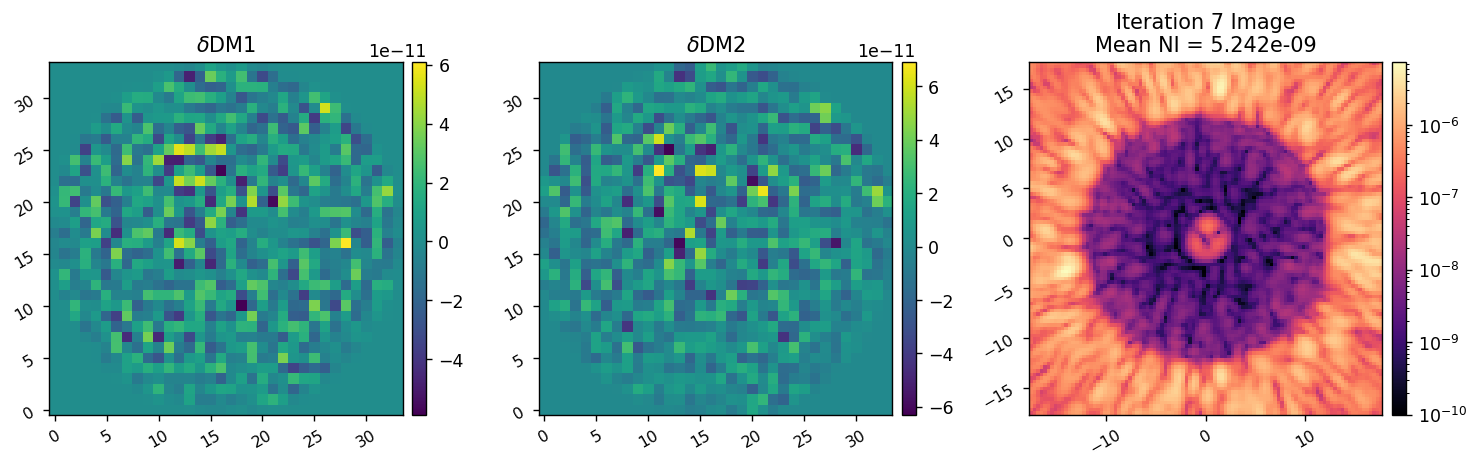

Running estimation algorithm ...
Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  5.60144D+08


 This problem is unconstrained.



At iterate    1    f=  9.90185D-01    |proj g|=  7.21479D+08

At iterate    2    f=  9.58249D-01    |proj g|=  2.42211D+08

At iterate    3    f=  9.53486D-01    |proj g|=  1.53034D+08

At iterate    4    f=  9.42855D-01    |proj g|=  1.60231D+08

At iterate    5    f=  9.35940D-01    |proj g|=  3.50397D+08

At iterate    6    f=  9.30792D-01    |proj g|=  1.18860D+08

At iterate    7    f=  9.28725D-01    |proj g|=  6.49479D+07

At iterate    8    f=  9.26872D-01    |proj g|=  7.42213D+07

At iterate    9    f=  9.24765D-01    |proj g|=  1.11427D+08

At iterate   10    f=  9.22435D-01    |proj g|=  1.08409D+08

At iterate   11    f=  9.20511D-01    |proj g|=  7.42546D+07

At iterate   12    f=  9.18608D-01    |proj g|=  7.86660D+07

At iterate   13    f=  9.16723D-01    |proj g|=  1.03466D+08

At iterate   14    f=  9.14977D-01    |proj g|=  1.08214D+08

At iterate   15    f=  9.13501D-01    |proj g|=  5.47926D+07

At iterate   16    f=  9.12248D-01    |proj g|=  6.42139D+07

At iter

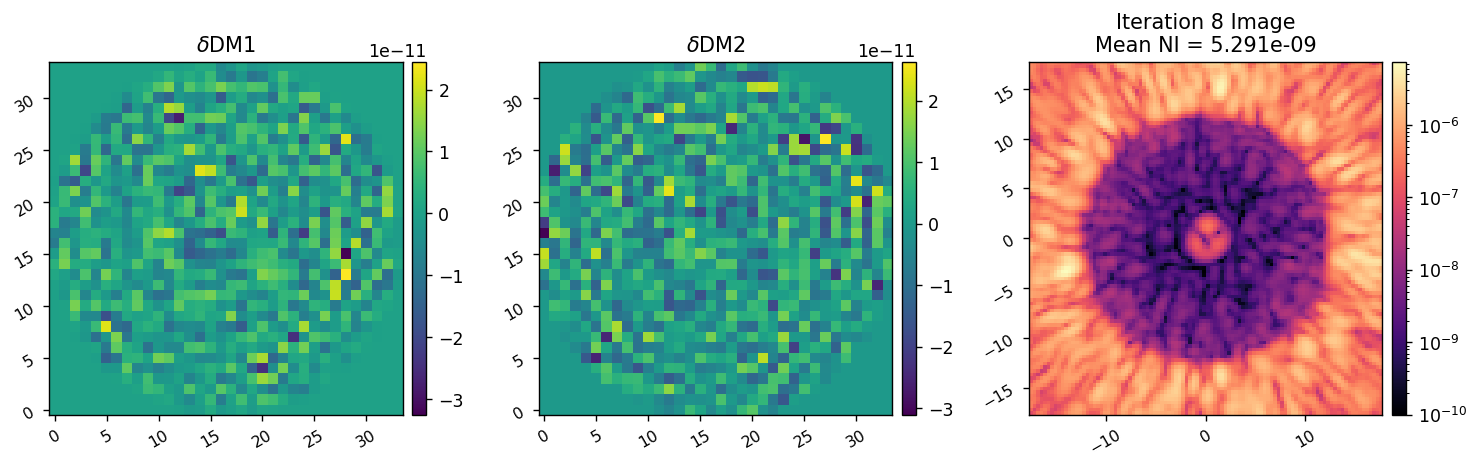

Running estimation algorithm ...
Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1904     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.40044D+08

At iterate    1    f=  9.96803D-01    |proj g|=  2.71642D+08

At iterate    2    f=  9.94636D-01    |proj g|=  9.24101D+07

At iterate    3    f=  9.93664D-01    |proj g|=  1.00150D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1904      3     16      1     0     0   1.002D+08   9.937D-01
  F =  0.99366382740446679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


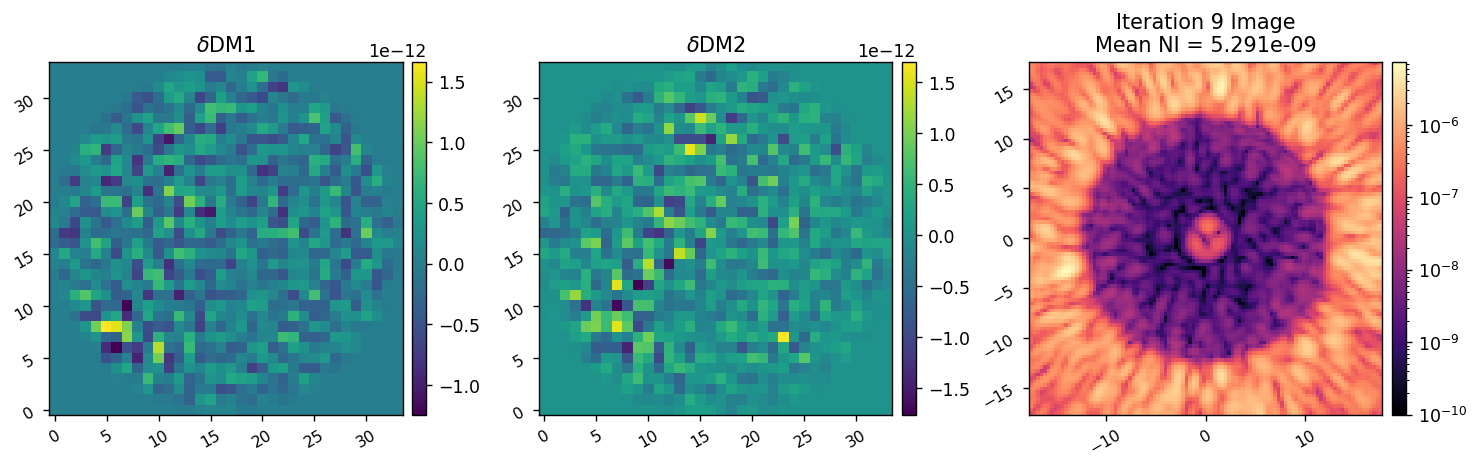

In [76]:
reload(fraunhofer)
reload(adefc)

r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxls':100, 
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run_bb(
    I, 
    M, 
    fraunhofer.val_and_grad_bb, 
    control_mask, 
    data,
    Nitr=3, 
    reg_cond=r_cond,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
)


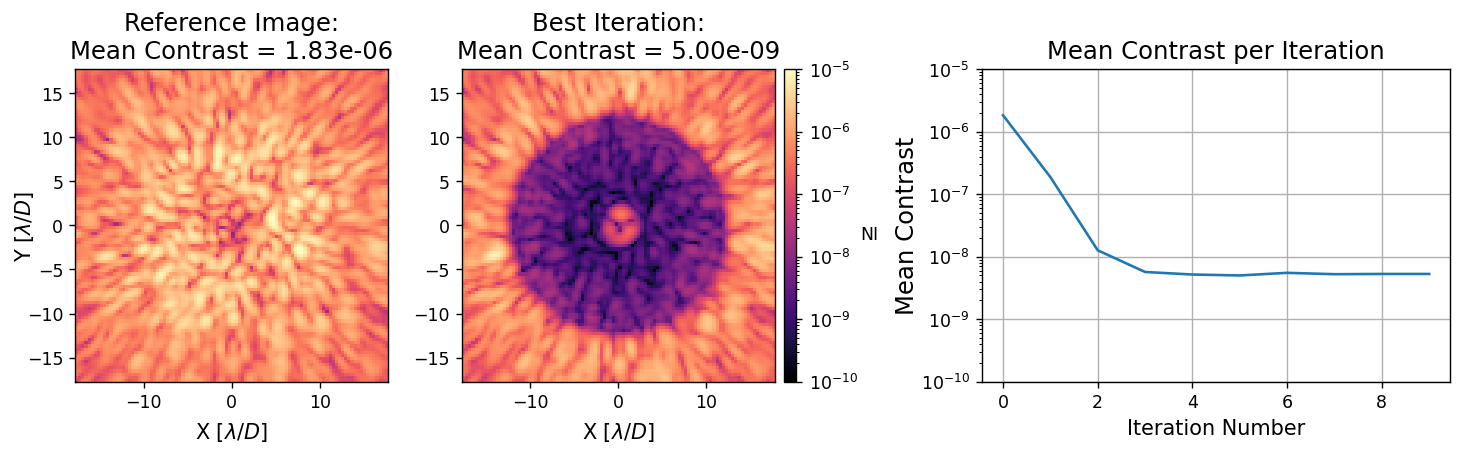

In [78]:
reload(adefc)
adefc.plot_data(data, vmax=1e-5)